# <center>Causal Variational Autoencoders</center>



### Abstract 

$T$he main objective of this project is to conceptualize Variational Autoencoders from the perspective of Causal Inference and establish a causal reltionship between images and the ground truth independent factors. We will also be studying the effecs of intervention and make attempts to answer counterfactual queries.


### Dataset
$dSprites$ is a dataset of sprites, which are 2D shapes procedurally generated from 6 ground truth independent "factors." These factors are color, shape, scale, rotation, x and y positions of a sprite.

- Color: white
- Shape: 3 values {square, ellipse, heart}
- Scale: 6 values linearly spaced in (0.5, 1)
- Orientation: 40 values in (0, 2 𝜋 )
- Position X: 32 values in (0, 1)
- Position Y: 32 values in (0, 1)

All possible combinations of these variables are present exactly once, generating N = 737280 total images.


Let's mount our google drive before we start so that we are able to use our dataset for training purpose and save our trained model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Installing the necessary dpackages
- Pyro Package - pyro is used for Deep Probabilistic Programming.
- Torch Vision Package - The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.
- Pydrive Package - File management made easy. Upload/update the file with one method. PyDrive will do it in the most efficient way.
- Tqdm Package - tqdm package is used to plot user-interactive plot used for visualization.



In [ ]:
!pip3 install pyro-ppl
!pip3 install torch torchvision
!pip3 install pydrive --upgrade
!pip3 install tqdm

Loading the necessary libraries

In [4]:
# Load necessary libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import os
from collections import defaultdict

import torch
import torch.nn as nn

from tqdm import tqdm
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, EmpiricalMarginal
from pyro.optim import Adam, SGD
import torch.distributions.constraints as constraints

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#to utilize GPU capabilities
USE_CUDA = True
# USE_CUDA = False

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

### GPU compatibility
$T$he project is made to be GPU compatible as the dataset comprises 737280 images of 64 x 64 dimensions each. Here, we allocate the GPU using packages like psutil, humanize and gputil packages.

In [ ]:
# Hack to get all available GPU ram.

import tensorflow as tf
tf.test.gpu_device_name()

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

### What are AutoEncoders..?
Autoencoder is an unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

An autoencoder accepts input, compresses it, and then recreates the original input. But this cannot be used for generation as the encoded feature space does not capture the underlying distribution. Changing values even a little in the feature space might render the image intangible.
![](https://drive.google.com/uc?export=view&id=1NwQzyoG-2qKlADrooOhSFjkSYJ2hWn5p)

### What are $Variational Autoencoder's$ and how are they better..?

A variational autoencoder assumes that the source data has some sort of underlying probability distribution (such as Gaussian) and then attempts to find the parameters of the distribution. The model learns the μ and σ and ensures continuity in the feature space. Thus, tweaking the same will lead to sensible images.

**They consist of two parts:**
- 1. Encoder - In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.
    - **Encoder Class**  which takes in as input the image`(xs)` and the label`(ys)` and feeds it to the forward function which gives the output as `z_loc` and `z_scale`(the mean and variance values which are used in sampling the latent variable`(zs)` from a normal distribution)
 
- 2. Decoder - In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

    - **Decoder Class** which takes in as input the latent variable`(zs`) and the image label`(ys)` and reconstructs a new image in the vicinity of the input image which was used to train the variational autoencoder.

![](https://drive.google.com/uc?export=view&id=1tC7wdfYwa3btZEBXthDo3PG96GnHAZV9)



In [6]:
class EncoderY(nn.Module):
		"""
		MLP-based encoder for Y.
		
		This is used for inference of Y. In the model, each element of Y is drawn
		from its own distribution.  However, during inference, we will sample values
		of Y from a multivariate Gaussian.
		"""
		def __init__(self, image_dim, label_dim):
			super(EncoderY, self).__init__()
			#setup image and label dimensions from the dataset
			self.image_dim = image_dim
			self.label_dim = label_dim
		
			# setup the three linear transformations used
			self.fc1 = nn.Linear(image_dim, 1000)
			self.fc2 = nn.Linear(1000, 1000)
			self.fc31 = nn.Linear(1000, label_dim)  # mu values
			self.fc32 = nn.Linear(1000, label_dim)  # sigma values
			# setup the non-linearities
			self.softplus = nn.Softplus()

		def forward(self, xs):
			xs = xs.reshape(-1, self.image_dim)
			#now concatenate the image and label
			#inputs = torch.cat((xs,), -1)
			# then compute the hidden units
			hidden1 = self.softplus(self.fc1(xs))
			hidden2 = self.softplus(self.fc2(hidden1))
			# then return a mean vector and a (positive) square root covariance
			# each of size batch_size x z_dim
			y_loc = self.fc31(hidden2)
			y_scale = torch.exp(self.fc32(hidden2))
			return y_loc, y_scale

class EncoderZ(nn.Module):
	"""
    MLPs (multi-layered perceptrons or simple feed-forward networks)
    where the provided activation parameter is used on every linear layer except
    for the output layer where we use the provided output_activation parameter
	"""
	def __init__(self, image_dim, label_dim, z_dim):
		super(EncoderZ, self).__init__()
		#setup image and label dimensions from the dataset
		self.image_dim = image_dim
		self.label_dim = label_dim
		self.z_dim = z_dim
		# setup the three linear transformations used
		self.fc1 = nn.Linear(self.image_dim+self.label_dim, 1000)
		self.fc2 = nn.Linear(1000, 1000)
		self.fc31 = nn.Linear(1000, z_dim)  # mu values
		self.fc32 = nn.Linear(1000, z_dim)  # sigma values
		# setup the non-linearities
		self.softplus = nn.Softplus()

	def forward(self, xs, ys):
		xs = xs.reshape(-1, self.image_dim)
		#now concatenate the image and label
		inputs = torch.cat((xs,ys), -1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		# then return a mean vector and a (positive) square root covariance
		# each of size batch_size x z_dim
		z_loc = self.fc31(hidden2)
		z_scale = torch.exp(self.fc32(hidden2))
		return z_loc, z_scale

class Decoder(nn.Module):
	def __init__(self, image_dim, label_dim, z_dim):
		super(Decoder, self).__init__()
		# setup the two linear transformations used
		hidden_dim = 1000
		self.fc1 = nn.Linear(z_dim+label_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, hidden_dim)
		self.fc3 = nn.Linear(hidden_dim, hidden_dim)
		self.fc4 = nn.Linear(hidden_dim, image_dim)
		# setup the non-linearities
		self.softplus = nn.Softplus()
		self.sigmoid = nn.Sigmoid()

	def forward(self, zs, ys):
		inputs = torch.cat((zs, ys),-1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		hidden3 = self.softplus(self.fc3(hidden2))
		# return the parameter for the output Bernoulli
		# each is of size batch_size x 784
		loc_img = self.sigmoid(self.fc4(hidden3))
		return loc_img

### Why do we need to introduce Causality..?
$I$n real scenarios, features are not necessarily independent. Instead, there might be an underlying causal structure which renders these features dependent. Looking at data and relationships from a causal perspectives helps us to understand this underlying distributions and aids us in data generating process.

Learning disentanglement aims at finding a low dimensional representation consisting of multiple explanatory and generative factors of the observational data. The VAE framework is commonly used to disentangle independent factors from observations. 


### Causal Variational Autoencoders


This module implements the Causal Effect Variational Autoencoder, which demonstrates a number of innovations including:

- a generative model for causal effect inference with hidden confounders;
- a model and guide with twin neural nets to allow imbalanced treatment; and
- a custom training loss that includes both ELBO terms and extra terms needed to train the guide to be able to answer counterfactual queries.


class Model(config) 

Generative model for a causal model with latent confounder z and binary treatment t:

    z ~ p(z)      # latent confounder
    x ~ p(x|z)    # partial noisy observation of z
    t ~ p(t|z)    # treatment, whose application is biased by z
    y ~ p(y|t,z)  # outcome

Each of these distributions is defined by a neural network. The y distribution is defined by a disjoint pair of neural networks defining p(y|t=0,z) and p(y|t=1,z); this allows highly imbalanced treatment.

class Guide(config)

Inference model for causal effect estimation with latent confounder z and binary treatment t:

    t ~ q(t|x)      # treatment
    y ~ q(y|t,x)    # outcome
    z ~ q(z|y,t,x)  # latent confounder, an embedding

Each of these distributions is defined by a neural network. The y and z distributions are defined by disjoint pairs of neural networks defining $p(-|t=0,...) and p(-|t=1,...)$  this allows highly imbalanced treatment.


classTraceCausalEffect_ELBO

Loss function for training a CEVAE. From [1], the CEVAE objective (to maximize) is:

    -loss = ELBO + log q(t|x) + log q(y|t,x)

users may customize by using components Model, Guide, TraceCausalEffect_ELBO and utilities.


![](https://drive.google.com/uc?export=view&id=1YunAP9nDwrIzYYsMFv5OyEu4k1NuKShZ)

In [7]:
class CVAE(nn.Module):
	"""
	This class encapsulates the parameters (neural networks) and models & guides 
	needed to train a supervised variational auto-encoder 
	"""
	def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):
		
		super(CVAE, self).__init__()
		self.image_dim = 64**2
		self.label_shape = np.array((1,3,6,40,32,32))
		self.label_names = np.array(('color', 'shape', 'scale', 'orientation', 'posX', 'posY'))
		self.label_dim = np.sum(self.label_shape)
		self.z_dim = 50                                           
		self.allow_broadcast = config_enum == 'parallel'
		self.use_cuda = use_cuda
		self.aux_loss_multiplier = aux_loss_multiplier
			# define and instantiate the neural networks representing
			# the paramters of various distributions in the model
		self.setup_networks()

	def setup_networks(self):
		"""
		Setup and initialize encoder and decoder units
		"""
		self.encoder_y = EncoderY(self.image_dim, 4)
		self.encoder_z = EncoderZ(self.image_dim, self.label_dim, self.z_dim)
		self.decoder = Decoder(self.image_dim, self.label_dim, self.z_dim)
		# using GPUs for faster training of the networks
		if self.use_cuda:
				self.cuda()

	def model(self, xs_obs, ys_obs):
			pyro.module("cvae", self)
			batch_size = xs_obs.size(0)
			options = dict(dtype=xs_obs.dtype, device=xs_obs.device)
			zero_vec = torch.zeros([batch_size], **options)

			def p_Z():
					prior_loc = torch.zeros(batch_size, self.z_dim, **options)
					prior_scale = torch.ones(batch_size, self.z_dim, **options)
					zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))
					return zs
				
			def p_Y(ys_obs):
					num_shapes = 3
					one_vec = torch.ones([batch_size], **options)
					shape_probs = torch.ones([batch_size, num_shapes], **options)  # 3 shapes
					orientation_probs = torch.ones([batch_size, 40], **options)  # 40 orientation vals
					
					_, shape_obs, scale_obs, orient_obs, pos_x_obs, pos_y_obs = ys_obs.t()

					# sample the shapes
					shape = pyro.sample('shape', dist.Categorical(probs=shape_probs), obs=shape_obs.int())
					scale = pyro.sample('scale', dist.Uniform(zero_vec, one_vec*40), obs=scale_obs)
					orientation = pyro.sample(
							'orientation',
							dist.Uniform(zero_vec, one_vec*40),
							obs=orient_obs
					)
					position_x = pyro.sample('x_pos', dist.Uniform(zero_vec, one_vec*32), obs=pos_x_obs)
					position_y = pyro.sample('y_pos', dist.Uniform(zero_vec, one_vec*32), obs=pos_y_obs)

					ys = torch.stack((zero_vec, shape.float(), scale, orientation, position_x, position_y)).t()
					return ys

			def f_X_obs(ys, zs, xs_obs):
					# if the label y (which digit to write) is supervised, sample from the
					# constant prior, otherwise, observe the value (i.e. score it against
					# the constant prior)
					loc = self.decoder.forward(zs, self.p_Y_onehot(ys))
					xs = pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs_obs)
					return xs

			with pyro.plate("data"):
					zs = p_Z()
					ys = p_Y(ys_obs)
					xs = f_X_obs(ys, zs, xs_obs)
					return xs, ys

	def p_Y_onehot(self, ys): # Is this better? At least it works
				new_ys = []
				options = dict(dtype=ys.dtype, device=ys.device)
				for i, label_length in enumerate(self.label_shape):
						prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
						new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
																	obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
				new_ys = torch.cat(new_ys, -1)
				return new_ys.to(torch.float32)
	
	def guide(self, xs, ys):
		with pyro.plate("data"):
			z_loc, z_scale = self.encoder_z.forward(xs, self.p_Y_onehot(ys))
			pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

	def remap_y(self, ys):
		new_ys = []
		options = dict(dtype=ys.dtype, device=ys.device)
		for i, label_length in enumerate(self.label_shape):
		    prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
		    new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
		                           obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
		new_ys = torch.cat(new_ys, -1)
		return new_ys.to(torch.float32)

	

	def reconstruct_image(self, xs, ys):
		# backward
		sim_z_loc, sim_z_scale = self.encoder_z.forward(xs, self.p_Y_onehot(ys))
		zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
		# forward
		loc = self.decoder.forward(zs, self.p_Y_onehot(ys))
		return dist.Bernoulli(loc).to_event(1).sample()

### Data Preprocessing
$The$ dataset is split in test and train  both for the images and the labels. The below code snippet explains how the dataset is combined and stored in the data_loader dictionary. 

`Note:` There are six types of labels for a single image therefore, the labels are split as well in the similar format and stored  in a dictionary inside the data_loader function.

In [8]:
def setup_data_loaders(train_x, test_x, train_y, test_y, batch_size=128, use_cuda=False):
	train_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(train_y.astype(np.float32))
	)
	test_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(test_y.astype(np.float32))
	)    
	kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
	train_loader = torch.utils.data.DataLoader(
	  dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
	)

	test_loader = torch.utils.data.DataLoader(
	  dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
	)
	return {"train":train_loader, "test":test_loader}

### Loading the dataset

$The$ dataset is now loaded from our mounted Google Drive.  A set of sampled images from the loaded dataset, along with labels sampled is created and passed into setup_data_loaders function to prepare the data loaders dictionary which comprises of the train and the test data.

In [9]:
dataset_zip = np.load(
    '/content/drive/MyDrive/Causal_7290_Code/Causal-Inference/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
    encoding = 'bytes',
    allow_pickle=True
)

imgs = dataset_zip['imgs']
labels = dataset_zip['latents_classes']
label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
label_names = dataset_zip['metadata'][()][b'latents_names']

# Sample imgs randomly
indices_sampled = np.arange(imgs.shape[0])
np.random.shuffle(indices_sampled)
imgs_sampled = imgs[indices_sampled]
labels_sampled = labels[indices_sampled]

data_loaders = setup_data_loaders(
   imgs_sampled[1000:],
   imgs_sampled[:1000],
   labels_sampled[1000:],
   labels_sampled[:1000],
   batch_size=256,
   use_cuda=USE_CUDA
)


### Training the Model

$The$ SVI (Stochastic Variational Inference) in Pyro was used to compute the losses from the train and the test dataset.

The SVI object has 2 methods, 
- **.step()**:takes a single gradient step and returns an estimate of the loss (i.e. minus the ELBO). If provided, the arguments to step() are piped to model() and guide().
- **.evaluate_loss()** : returns an estimate of the loss without taking a gradient step. Just like for step(), if provided, arguments to evaluate_loss() are piped to model() and guide()

In [10]:
def train(svi, train_loader, use_cuda=False):
	# initialize loss accumulator
	epoch_loss = 0.
	# do a training epoch over each mini-batch x returned
	# by the data loader
	for xs,ys in train_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # do ELBO gradient and accumulate loss
	  epoch_loss += svi.step(xs, ys)
	# return epoch loss
	normalizer_train = len(train_loader.dataset)
	total_epoch_loss_train = epoch_loss / normalizer_train
	return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
	# initialize loss accumulator
	test_loss = 0.
	# compute the loss over the entire test set
	for xs, ys in test_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # compute ELBO estimate and accumulate loss
	  test_loss += svi.evaluate_loss(xs, ys)
	normalizer_test = len(test_loader.dataset)
	total_epoch_loss_test = test_loss / normalizer_test
	return total_epoch_loss_test

Used Hyperparameters: 
- learning rate = 1.0e-3 and 
- number of iterations = 10
- testing frequency = 5

In [11]:
# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 10
TEST_FREQUENCY = 5

Here the model is trained by setting up the SVI inference algorithm. 

Adam optimizer was utilzed.


The svi.step() and svi.evaluate() functions were used to compute the losses for the train and test data for evaluating our model.


In [12]:
import warnings
warnings.filterwarnings('ignore')

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = CVAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

VERBOSE = True
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, data_loaders["train"], use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    if VERBOSE:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loaders["test"], use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        if VERBOSE:
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 000]  average training loss: 180.0718


 10%|█         | 1/10 [01:46<16:01, 106.83s/it]

[epoch 000] average test loss: 119.1862


 20%|██        | 2/10 [03:34<14:16, 107.00s/it]

[epoch 001]  average training loss: 92.9595


 30%|███       | 3/10 [05:23<12:33, 107.57s/it]

[epoch 002]  average training loss: 81.9519


 40%|████      | 4/10 [07:11<10:47, 107.85s/it]

[epoch 003]  average training loss: 60.2432


 50%|█████     | 5/10 [09:00<09:00, 108.17s/it]

[epoch 004]  average training loss: 48.1666
[epoch 005]  average training loss: 38.6646


 60%|██████    | 6/10 [10:49<07:13, 108.40s/it]

[epoch 005] average test loss: 39.3639


 70%|███████   | 7/10 [12:38<05:26, 108.68s/it]

[epoch 006]  average training loss: 35.6741


 80%|████████  | 8/10 [14:24<03:35, 107.70s/it]

[epoch 007]  average training loss: 34.1635


 90%|█████████ | 9/10 [16:11<01:47, 107.68s/it]

[epoch 008]  average training loss: 33.0933


100%|██████████| 10/10 [17:58<00:00, 107.84s/it]

[epoch 009]  average training loss: 32.2103


### Saving the Model

$The$ results and the trained model were saved to avoid retraining and reusability.


In [13]:
#################################
### FOR SAVING AND LOADING MODEL
################################
# clear param store

pyro.clear_param_store()

network_path = "/content/drive/MyDrive/Causal_7290_Code/Causal-Inference/trained_model_3.save"
torch.save(vae.state_dict(), network_path)

### Loading Our Trained Model
$The$ previously saved model was loaded in the following snippet.

In [ ]:
network_path = "/content/drive/MyDrive/Causal_7290_Code/Causal-Inference/trained_model_2.save"

vae=CVAE(use_cuda=USE_CUDA)
vae.load_state_dict(torch.load(network_path))

<All keys matched successfully>

### Loss Vs Epochs
`Observation:` The given hyperparameters used are performing well, as after 10 epochs there is no significant change in the training losses.

Text(0, 0.5, 'Loss')

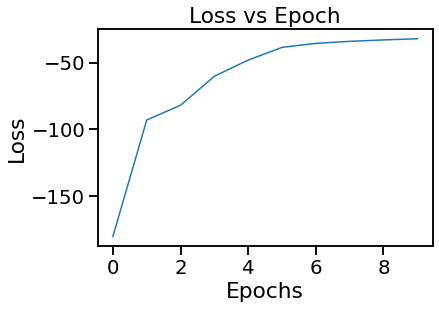

In [14]:
#Plotting the loss now
import seaborn as sns
sns.lineplot(data=train_elbo)
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Visualizing the Reconstructions 
$Here$, the original image was compared with the one reconstructed form the decoder of VAE (Without interventions).


Pending

In [ ]:
import warnings
warnings.filterwarnings("ignore")

data_iter = iter(data_loaders["test"])
xs, ys = next(data_iter)

if USE_CUDA:
    xs = xs.cuda()
    ys = ys.cuda()

rs = vae.reconstruct_image(xs, ys)
if USE_CUDA:
    xs = xs.cpu()
    rs = rs.cpu()
originals = xs.numpy().reshape(-1, 64,64)
recons = rs.reshape(-1,64,64)

In [ ]:
def recon_check(original, recon):
  fig = plt.figure()
  ax0 = fig.add_subplot(121)
  plt.imshow(original, cmap='Greys_r',  interpolation='nearest')
  plt.axis('off')
  ax1 = fig.add_subplot(122)
  plt.imshow(recon , cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  
def f(x):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(originals[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recons[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    
interact(f, x=widgets.IntSlider(min=0, max=xs.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=255), Output()), _dom_classes=('widget-interact'…

<function __main__.f>

In [ ]:
y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
y_shapes = np.array((3,6,40,32,32))
img_dict = {}

for i, img in enumerate(imgs_sampled):
     img_dict[tuple(labels_sampled[i])] = img

def find_in_dataset(shape, scale, orient, posX, posY):
  fig = plt.figure()
  img = img_dict[(0, shape, scale, orient, posX, posY)]
  plt.imshow(img.reshape(64,64), cmap='Greys_r', interpolation='nearest')
  plt.axis('off')

interact(find_in_dataset, 
         shape=widgets.IntSlider(min=0, max=2, step=1, value=0),
         scale=widgets.IntSlider(min=0, max=5, step=1, value=0),
         orient=widgets.IntSlider(min=0, max=39, step=1, value=0),
         posX=widgets.IntSlider(min=0, max=31, step=1, value=0),
         posY=widgets.IntSlider(min=0, max=31, step=1, value=0))

interactive(children=(IntSlider(value=0, description='shape', max=2), IntSlider(value=0, description='scale', …

<function __main__.find_in_dataset>

## Helper Functions

This function is used to get examples of data with specific class labels

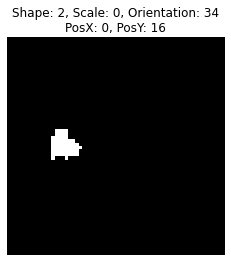

In [ ]:
def get_specific_data(args=dict(), cuda=False):
    '''
    
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        cuda - bool to indicate whether the output should be placed on GPU
    '''
    names_dict = {'shape': 1, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
    selected_ind = np.ones(imgs.shape[0], dtype=bool)
    for k,v in args.items():
        col_id = names_dict[k]
        selected_ind = np.bitwise_and(selected_ind, labels[:, col_id] == v)
    ind = np.random.choice(np.arange(imgs.shape[0])[selected_ind])
    x = torch.from_numpy(imgs[ind].reshape(1,64**2).astype(np.float32))
    y = torch.from_numpy(labels[ind].reshape(1,6).astype(np.float32))
    if not cuda:
        return x,y
    x = x.cuda()
    y = y.cuda()
    return x,y

def plot_image(x):
    """
    helper to plot dSprites images
    """
    x = x.cpu()
    plt.figure()
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

def see_specific_image(args=dict(), verbose=True):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        verbose - bool to indicate whether the full class label should be written 
                    as the title of the plot
    '''
    x,y = get_specific_data(args, cuda=False)
    plot_image(x)
    if verbose:
        string = ''
        for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
            string += '%s: %d, ' % (s, int(y[0][i+1]))
            if i == 2:
                string = string[:-2] + '\n'
        plt.title(string[:-2], fontsize=12)
        
def compare_reconstruction(original, recon):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array for recon image
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(recon.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstruction')
    
def compare_to_density(original, recons):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array of multiple recon images
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(torch.mean(recons.cpu(), 0).reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstructions')

        
see_specific_image()

In [ ]:
label_dims = vae.label_shape
label_dim_offsets = np.cumsum(label_dims)
label_dim_offsets

array([  1,   4,  10,  50,  82, 114])

### Structural Causal Model (SCM)
$First$ let us first understand what are exogenous and endogenous variables.
- **Exogeneous Variables:** A factor in a causal model whose value is independent from the states of other variables in the system.
- **Endogenous Variables:** A factor in a causal model whose value is determined by the states of other variables in the system.

Going further.

A Structural causal model was implemented capturing the causal dependencies of the endogenous and exogenous variables in our model. An object of class SCM() takes in 3 arguments, an instance of a VAE, loc of q(z|x) given by the VAE encoder, and the sigma of q(z|x) also given by the VAE encoder.

![](https://drive.google.com/uc?export=view&id=1iVAxQXdeV8Ec6NrLk-J1sUv1Wft7kL_l)

#### Endogenous Variables
These are of 3 types:- 
- 1.dSprite image(X),

- 2.labels corresponding to the image(Y),

- 3.latent variable(Z) sampled from a normal distribution with mean and variance returned by the variational autoencoder. 

Y is further subdivided into 5 variables `‘Y_1’, ‘Y_2’, ‘Y_3’, ‘Y_4’, and ‘Y5’` each of which represent the individual image label.

#### Exogenous Variables
These are represented by noises corresponding to each of the endogenous variables with a suffix ‘N’.

#### Function Description

**model():**
This function corresponds to our` data generative process`. It takes in input as argument the noise variables i.e the exogenous variables and returns X(image), Y(labels), and Z(latents). It does so by sampling the individual endogenous variables using a normal probability distribution.

**updated_noise_svi()**
This function takes in as input the labels of an image in the form of a dictionary (obs_data), and an optional intervened model(intervened_model) and returns the exogenous variables or noises corresponding to the images (obs_data).

It uses SVI to find out the μ and σ of the distribution for the conditions outlined in obs_data.The guide function serves as an approximation to the posterior p(z|x). The guide provides a valid joint probability density over all the latent random variables in the model.Once the guide is specified and the model is conditioned, we move to the inference step. Now, this is an optimization problem where each iteration of training takes a step that moves the guide closer to the exact posterior.

In [ ]:
class SCM():
    """
    Structural causal model
    
    args: 
      vae: instance of vae
      mu: loc of q(z|x) given by the vae encoder
      sigma: scale of q(z|x) given by the vae encoder
    
    """
    def __init__(self, vae, mu, sigma):
        """
        Constructor
        
        Intializes :
          image dimensions - 4096(64*64), 
          z dimensions: size of the tensor representing the latent random variable z, 
          label dimensions: 114 labels y that correspond to an image(one hot encoded)
          f(x) = p(x|y,z)
          Noise variables in the model N_#
        """
        self.vae = vae
        self.image_dim = vae.image_dim
        self.z_dim = vae.z_dim
        # these are used for f_X
        self.label_dims = vae.label_shape
        
        def f_X(Y, Z, N):
            """
            Generating one hots for the factors
            """ 
            zs = Z.cuda()
            # convert the labels to one hot
            ys = [torch.tensor([0])]
            ys.append(torch.nn.functional.one_hot(torch.round(Y[0]).to(torch.long), int(self.label_dims[1])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[1]).to(torch.long), int(self.label_dims[2])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[2]).to(torch.long), int(self.label_dims[3])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[3]).to(torch.long), int(self.label_dims[4])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[4]).to(torch.long), int(self.label_dims[5])))
            ys = torch.cat(ys).to(torch.float32).reshape(1,-1).cuda()
            p = vae.decoder.forward(zs, ys)
            return (N < p.cpu()).type(torch.float)
        
        def f_Y(N):
            """
            Gumbel distribution - to model the distribution of the maximum of a number of samples
            m = Gumbel(torch.tensor([1.0]), torch.tensor([2.0])).sample() # sample from Gumbel distribution with loc=1, scale=2
            tensor([ 1.0124])
            
            https://pytorch.org/docs/stable/_modules/torch/distributions/gumbel.html
            """
#             m = torch.distributions.gumbel.Gumbel(torch.zeros(N.size(0)), torch.ones(N.size(0)))
            beta = 12
            indices = torch.tensor(np.arange(N.size(0))).to(torch.float32)
            smax = nn.functional.softmax(beta*N)
            argmax_ind = torch.sum(smax*indices)
            return argmax_ind
        
        def f_Z(N):
            """
            Z ~ Normal(mu, sigma) 
            """
            return N * sigma + mu
        
        def model(noise): 
            """
            The model corresponds to a generative process
            
            args: noise variables
            return: X(image), Y(labels), Z(latents) 
            """
            N_X = pyro.sample( 'N_X', noise['N_X'].to_event(1) )
            # denoted using the index in the sequence 
            # that they are stored in as vae.label_names:
            # ['shape', 'scale', 'orientation', 'posX', 'posY']
            N_Y_1 = pyro.sample( 'N_Y_1', noise['N_Y_1'].to_event(1) )
            N_Y_2 = pyro.sample( 'N_Y_2', noise['N_Y_2'].to_event(1) )
            N_Y_3 = pyro.sample( 'N_Y_3', noise['N_Y_3'].to_event(1) )
            N_Y_4 = pyro.sample( 'N_Y_4', noise['N_Y_4'].to_event(1) )
            N_Y_5 = pyro.sample( 'N_Y_5', noise['N_Y_5'].to_event(1) )
            
            # Z ~ Normal(Nx_mu, Nx_sigma)              
            N_Z = pyro.sample( 'N_Z', noise['N_Z'].to_event(1) )
            Z = pyro.sample('Z', dist.Normal( f_Z( N_Z ), 1e-1).to_event(1) )
            
            # Y ~ Gumbel max of Ny             
#             Y_1_mu = f_Y(N_Y_1)
#             Y_2_mu = f_Y(N_Y_2)
#             Y_3_mu = f_Y(N_Y_3)
#             Y_4_mu = f_Y(N_Y_4)
#             Y_5_mu = f_Y(N_Y_5)
       
            Y_1 = pyro.sample('Y_1', dist.Normal( f_Y(N_Y_1), 1e-2) )
            Y_2 = pyro.sample('Y_2', dist.Normal( f_Y(N_Y_2), 1e-1) )
            Y_3 = pyro.sample('Y_3', dist.Normal( f_Y(N_Y_3), 1e-1) )
            Y_4 = pyro.sample('Y_4', dist.Normal( f_Y(N_Y_4), 1e-1) )
            Y_5 = pyro.sample('Y_5', dist.Normal( f_Y(N_Y_5), 1e-1) )
            
#             Y_mu = (Y_1_mu, Y_2_mu, Y_3_mu, Y_4_mu, Y_5_mu)
            
            # X ~ p(x|y,z) = bernoulli(loc(y,z))             
            X = pyro.sample('X', dist.Normal( f_X( (Y_1, Y_2, Y_3,Y_4,Y_5), Z, N_X ), 1e-2).to_event(1))
            
            # return noise and variables
            noise_samples = N_X, (N_Y_1, N_Y_2, N_Y_3, N_Y_4, N_Y_5), N_Z
            variable_samples = X, (Y_1, Y_2, Y_3, Y_4, Y_5), Z
            return variable_samples, noise_samples
        
        self.model = model
        #Initialize all noise variables in the model         
        self.init_noise = {
            'N_X'   : dist.Uniform(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)),
            'N_Z'   : dist.Normal(torch.zeros(vae.z_dim), torch.ones(vae.z_dim)),
            'N_Y_1' : dist.Uniform(torch.zeros(self.label_dims[1]),torch.ones(self.label_dims[1])),
            'N_Y_2' : dist.Uniform(torch.zeros(self.label_dims[2]),torch.ones(self.label_dims[2])),
            'N_Y_3' : dist.Uniform(torch.zeros(self.label_dims[3]),torch.ones(self.label_dims[3])),
            'N_Y_4' : dist.Uniform(torch.zeros(self.label_dims[4]),torch.ones(self.label_dims[4])),
            'N_Y_5' : dist.Uniform(torch.zeros(self.label_dims[5]),torch.ones(self.label_dims[5]))            
        }
        
    def update_noise_svi(self, obs_data, intervened_model=None):
        """
        Use svi to find out the mu, sigma of the distributionsfor the 
        condition outlined in obs_data
        """
        
        def guide(noise):
            """
            The guide serves as an approximation to the posterior p(z|x). 
            The guide provides a valid joint probability density over all the 
            latent random variables in the model.
            
            https://pyro.ai/examples/svi_part_i.html
            """
            # create params with constraints
            mu = {
                'N_X': pyro.param('N_X_mu', 0.5*torch.ones(self.image_dim),constraint = constraints.interval(0., 1.)),
                'N_Z': pyro.param('N_Z_mu', torch.zeros(self.z_dim),constraint = constraints.interval(-3., 3.)),
                'N_Y_1': pyro.param('N_Y_1_mu', 0.5*torch.ones(self.label_dims[1]),constraint = constraints.interval(0., 1.)),
                'N_Y_2': pyro.param('N_Y_2_mu', 0.5*torch.ones(self.label_dims[2]),constraint = constraints.interval(0., 1.)),
                'N_Y_3': pyro.param('N_Y_3_mu', 0.5*torch.ones(self.label_dims[3]),constraint = constraints.interval(0., 1.)),
                'N_Y_4': pyro.param('N_Y_4_mu', 0.5*torch.ones(self.label_dims[4]),constraint = constraints.interval(0., 1.)),
                'N_Y_5': pyro.param('N_Y_5_mu', 0.5*torch.ones(self.label_dims[5]),constraint = constraints.interval(0., 1.))
                }
            sigma = {
                'N_X': pyro.param('N_X_sigma', 0.1*torch.ones(self.image_dim),constraint = constraints.interval(0.0001, 0.5)),
                'N_Z': pyro.param('N_Z_sigma', torch.ones(self.z_dim),constraint = constraints.interval(0.0001, 3.)),
                'N_Y_1': pyro.param('N_Y_1_sigma', 0.1*torch.ones(self.label_dims[1]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_2': pyro.param('N_Y_2_sigma', 0.1*torch.ones(self.label_dims[2]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_3': pyro.param('N_Y_3_sigma', 0.1*torch.ones(self.label_dims[3]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_4': pyro.param('N_Y_4_sigma', 0.1*torch.ones(self.label_dims[4]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_5': pyro.param('N_Y_5_sigma', 0.1*torch.ones(self.label_dims[5]),constraint = constraints.interval(0.0001, 0.5))
                }
            for noise_term in noise.keys():
                pyro.sample(noise_term, dist.Normal(mu[noise_term], sigma[noise_term]).to_event(1))
        
        # Condition the model
        if intervened_model is not None:
          obs_model = pyro.condition(intervened_model, obs_data)
        else:
          obs_model = pyro.condition(self.model, obs_data)
          
        pyro.clear_param_store()

        # Once we’ve specified a guide, we’re ready to proceed to inference. 
        # Now, this an optimization problem where each iteration of training takes  
        # a step that moves the guide closer to the exact posterior 
        
        # https://arxiv.org/pdf/1601.00670.pdf
        svi = SVI(
            model= obs_model,
            guide= guide,
            optim= SGD({"lr": 1e-5, 'momentum': 0.1}),
            loss=Trace_ELBO(retain_graph=True)
        )
        
        num_steps = 1500
        samples = defaultdict(list)
        for t in range(num_steps):
            loss = svi.step(self.init_noise)
#             if t % 100 == 0:
#                 print("step %d: loss of %.2f" % (t, loss))
            for noise in self.init_noise.keys():
                mu = '{}_mu'.format(noise)
                sigma = '{}_sigma'.format(noise)
                samples[mu].append(pyro.param(mu).detach().numpy())
                samples[sigma].append(pyro.param(sigma).detach().numpy())
        means = {k: torch.tensor(np.array(v).mean(axis=0)) for k, v in samples.items()}
        
        # update the inferred noise
        updated_noise = {
            'N_X'  : dist.Normal(means['N_X_mu'], means['N_X_sigma']),
            'N_Z'  : dist.Normal(means['N_Z_mu'], means['N_Z_sigma']),
            'N_Y_1': dist.Normal(means['N_Y_1_mu'], means['N_Y_1_sigma']),
            'N_Y_2': dist.Normal(means['N_Y_2_mu'], means['N_Y_2_sigma']),
            'N_Y_3': dist.Normal(means['N_Y_3_mu'], means['N_Y_3_sigma']),
            'N_Y_4': dist.Normal(means['N_Y_4_mu'], means['N_Y_4_sigma']),
            'N_Y_5': dist.Normal(means['N_Y_5_mu'], means['N_Y_5_sigma']),
        }
        return updated_noise
        
    def __call__(self):
        return self.model(self.init_noise)

## Sanity Check 1: Making sure VAE works

tensor([[ 0.,  1.,  0.,  6., 28.,  0.]], device='cuda:0')


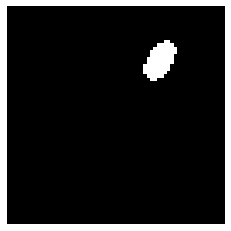

In [ ]:
# Generate an instance of dSprites image 
ox, y = get_specific_data(cuda=True)
plot_image(ox)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
mu, sigma = vae.encoder_z.forward(ox,vae.remap_y(y))
# Feed these params to our custom SCM
scm = SCM(vae, mu.cpu(), sigma.cpu())
print(y)
# Check for reconstruction

## Sanity Check 2: To check if the decoder is able to generate the image if the latents are changed:
To achieve this we manually change the labels in the code and run it through the decoder and check for reconstruction

top:  tensor([[ 0.,  2.,  3., 15., 26.,  2.]], device='cuda:0')
bottom:  tensor([[ 0.,  1.,  3., 15., 26.,  2.]], device='cuda:0')


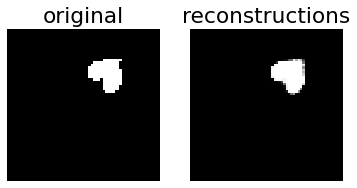

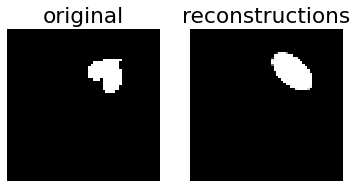

In [ ]:
original, y_original = get_specific_data(cuda=True)
print('top: ',y_original)
mu, sigma = vae.encoder_z.forward(original,vae.remap_y(y_original))
B = 100
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_original) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)

y_new = torch.tensor(y_original)
y_new[0,1] = (y_original[0,1] + 1) % 2
print('bottom: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)

### Conditioning with SCM VAE

To validate if causal inference of conditioning is properly working, we try to generate reconstruction of image by using SCM and object of SCM class. 

First random image is generated and its label is captured in dictionary which is passed to trained VAE object to get its mean and variance which is then used to create SCM class.

Then the noise of the input image is captured by passing the above dictionary and a conditioned model is created by using the object of SCM class.

The output noise is passed to conditioned model class to regenrate new images. Reconstruction is sampled 1000 times and displayed.


In [ ]:
cond_data = {}
for i in range(1, 6):
    cond_data["Y_{}".format(i)] = torch.tensor(y[0,i].cpu()).to(torch.float32)
print(cond_data)
# "Y_1": torch.tensor(2.),
    # "Y_2": torch.tensor(5.),
    # "Y_3": torch.tensor(2.),
    # "Y_4": torch.tensor(5.),
    # "Y_5": torch.tensor(25.),

# cond_data['Y_1'] = torch.tensor(2.)
# cond_data['Y_4'] =torch.tensor(.75)
cond_data['Y_5'] =torch.tensor(.75)
# cond_data['Y_2'] = torch.tensor(5.)
conditioned_model = pyro.condition(scm.model, data=cond_data)
cond_noise = scm.update_noise_svi(cond_data)
print(cond_data)

{'Y_1': tensor(1.), 'Y_2': tensor(0.), 'Y_3': tensor(6.), 'Y_4': tensor(28.), 'Y_5': tensor(0.)}
{'Y_1': tensor(1.), 'Y_2': tensor(0.), 'Y_3': tensor(6.), 'Y_4': tensor(28.), 'Y_5': tensor(0.7500)}


In [ ]:
cond_data['Y_2']

tensor(0.)

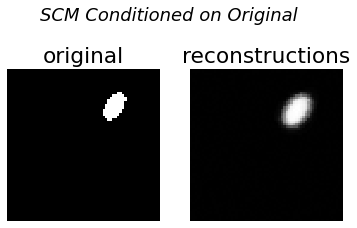

In [ ]:
rxs = []
for i in range(100):
     (rx,ry,_), _ = scm.model(cond_noise)
     rxs.append(rx)
compare_to_density(ox, torch.cat(rxs))
_ =plt.suptitle("SCM Conditioned on Original", fontsize=18, fontstyle='italic')

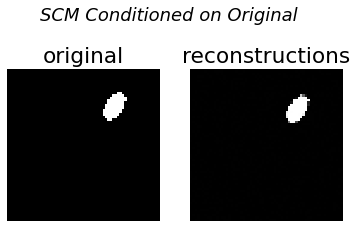

In [ ]:
rxs = []
for i in range(100):
     (rx,ry,_), _ = conditioned_model(scm.init_noise)
     rxs.append(rx)
compare_to_density(ox, torch.cat(rxs))
_ =plt.suptitle("SCM Conditioned on Original", fontsize=18, fontstyle='italic')

## Counterfactuals and Interventions

Here we tried to capture the effect of couterfactual and intervention on the dsprite image dataset by making use of endogenous and exogenous variables using an SCM class object.

We applied counterfactual interventions on the input image in 3 steps -

- Abduction Step:
  We find mean and variance by passing image and its label to trained VAE to create object of SCM class. Thereafter label dictionary is used to capture the noise of the input image.

- Action Step:
Here we intervene on SCM object as per out requirement of condition we want to intervene by using pyro.do

- Prediction Step:
Lastly we sample the image 1000 times passing the input object noise to the intervened model and generating the output image. We store these 1000 image in a list and use it for reconstruction


![](https://drive.google.com/uc?export=view&id=1eVN8MAXAxDlrd6lutsP2YjAMdzCR6rxb)



In [ ]:
# intervening on Shape, posX and PosY 
intervened_model = pyro.do(scm.model, data={
    "Y_1": torch.tensor(0.),
    "Y_2": torch.tensor(0.67),
   "Y_5": torch.tensor(0.09),
})
noise_data = {}
for term, d in cond_noise.items():
  noise_data[term] = d.loc
intervened_noise = scm.update_noise_svi(noise_data, intervened_model)

(tensor(0.), tensor(0.6700), tensor(18.8828), tensor(16.8866), tensor(0.0900))


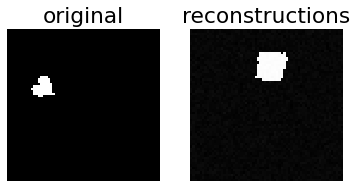

In [ ]:
(rx1,ry,_), _ = intervened_model(scm.init_noise)
compare_to_density(ox, rx1)
print(ry)

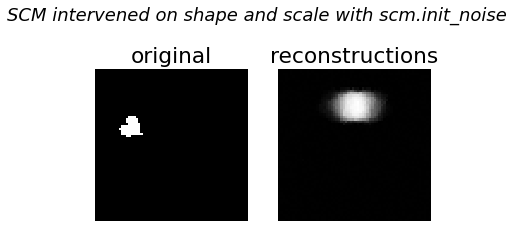

In [ ]:
rxs = []
for i in range(100):
     (cfo1,ny1,nz1), _= intervened_model(scm.init_noise)
     rxs.append(cfo1)
compare_to_density(ox, torch.cat(rxs))
_ =plt.suptitle("SCM intervened on shape and scale with scm.init_noise", fontsize=18, fontstyle='italic')

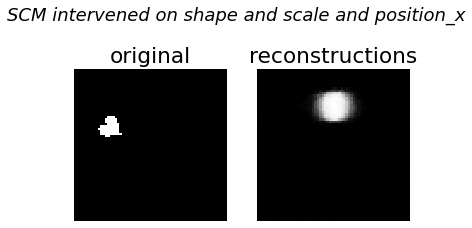

In [ ]:
#  with intervened_noise
rxs = []
for i in range(100):
     (cfo1,ny1,nz1), _= intervened_model(intervened_noise)
     rxs.append(cfo1)
compare_to_density(ox, torch.cat(rxs))
_ =plt.suptitle("SCM intervened on shape and scale and position_x", fontsize=18, fontstyle='italic')

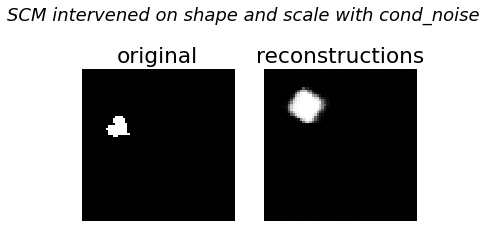

In [ ]:
rxs = []
for i in range(100):
     (cfo1,ny1,nz1), _= intervened_model(cond_noise)
     rxs.append(cfo1)
compare_to_density(ox, torch.cat(rxs))
_ =plt.suptitle("SCM intervened on shape and scale with cond_noise", fontsize=18, fontstyle='italic')

## Applications of CVAE:

- Deepfakes - Counterfactual and Interventions is used to create fake images of human faces
- Music VAE - Produces synthetic video